In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy as sp

In [2]:
adata = sc.read_h5ad('../../data/from_spatial_omics/Slide-seqV2/Slide-seqV2_stickels2020highly_stickels2021highly_Slide-seqV2_Mouse_SomatosensoryCortex_Puck_200306_03_data_whole.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 42550 × 22542
    obs: 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [5]:
adata.layers['counts'] = adata.X.copy()

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=500)

In [7]:
adata

AnnData object with n_obs × n_vars = 21941 × 6435
    obs: 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

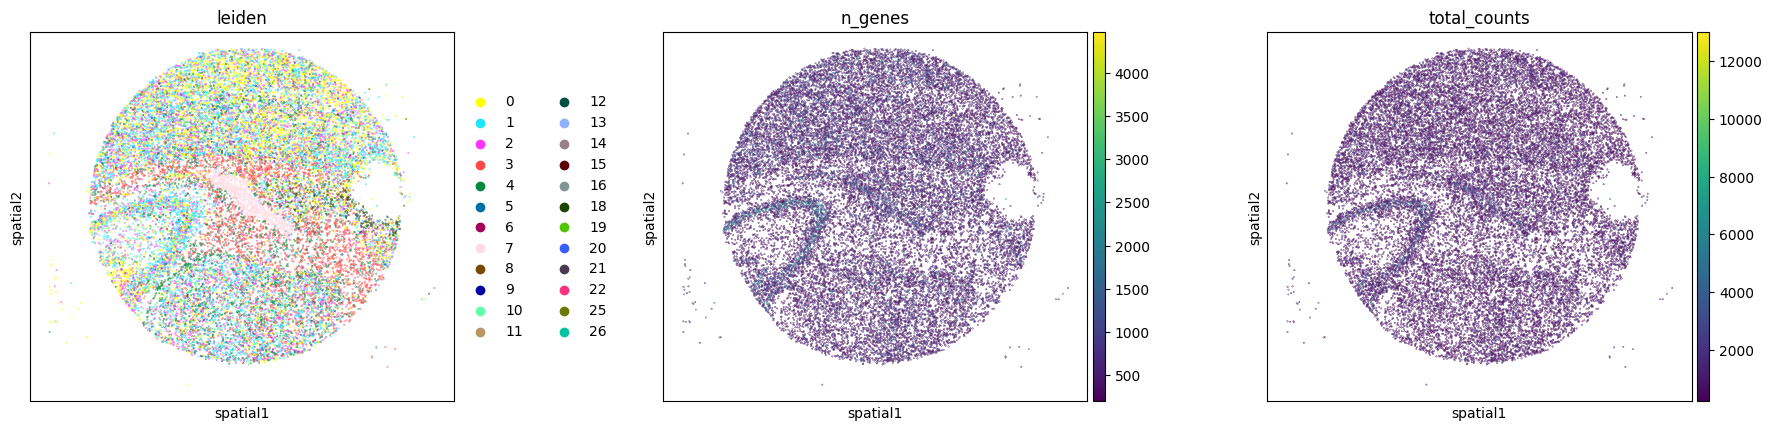

In [8]:
sq.pl.spatial_scatter(adata, color=['leiden', 'n_genes', 'total_counts'], size=0.1, shape=None)

In [9]:
# remove MT genes
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('mt-')]
adata = adata[:, non_mito_genes_list]

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(adata, mode="moran", 
                       n_perms=100, n_jobs=10, 
                       genes=adata.var_names)

100%|██████████| 100/100 [00:43<00:00,  2.32/s]


In [12]:
top_autocorr = (
    adata.uns["moranI"]["I"].sort_values(ascending=False).head(10).index.tolist()
)

In [13]:
# select top 50 variable genes as reference
adata = adata[:, top_autocorr]

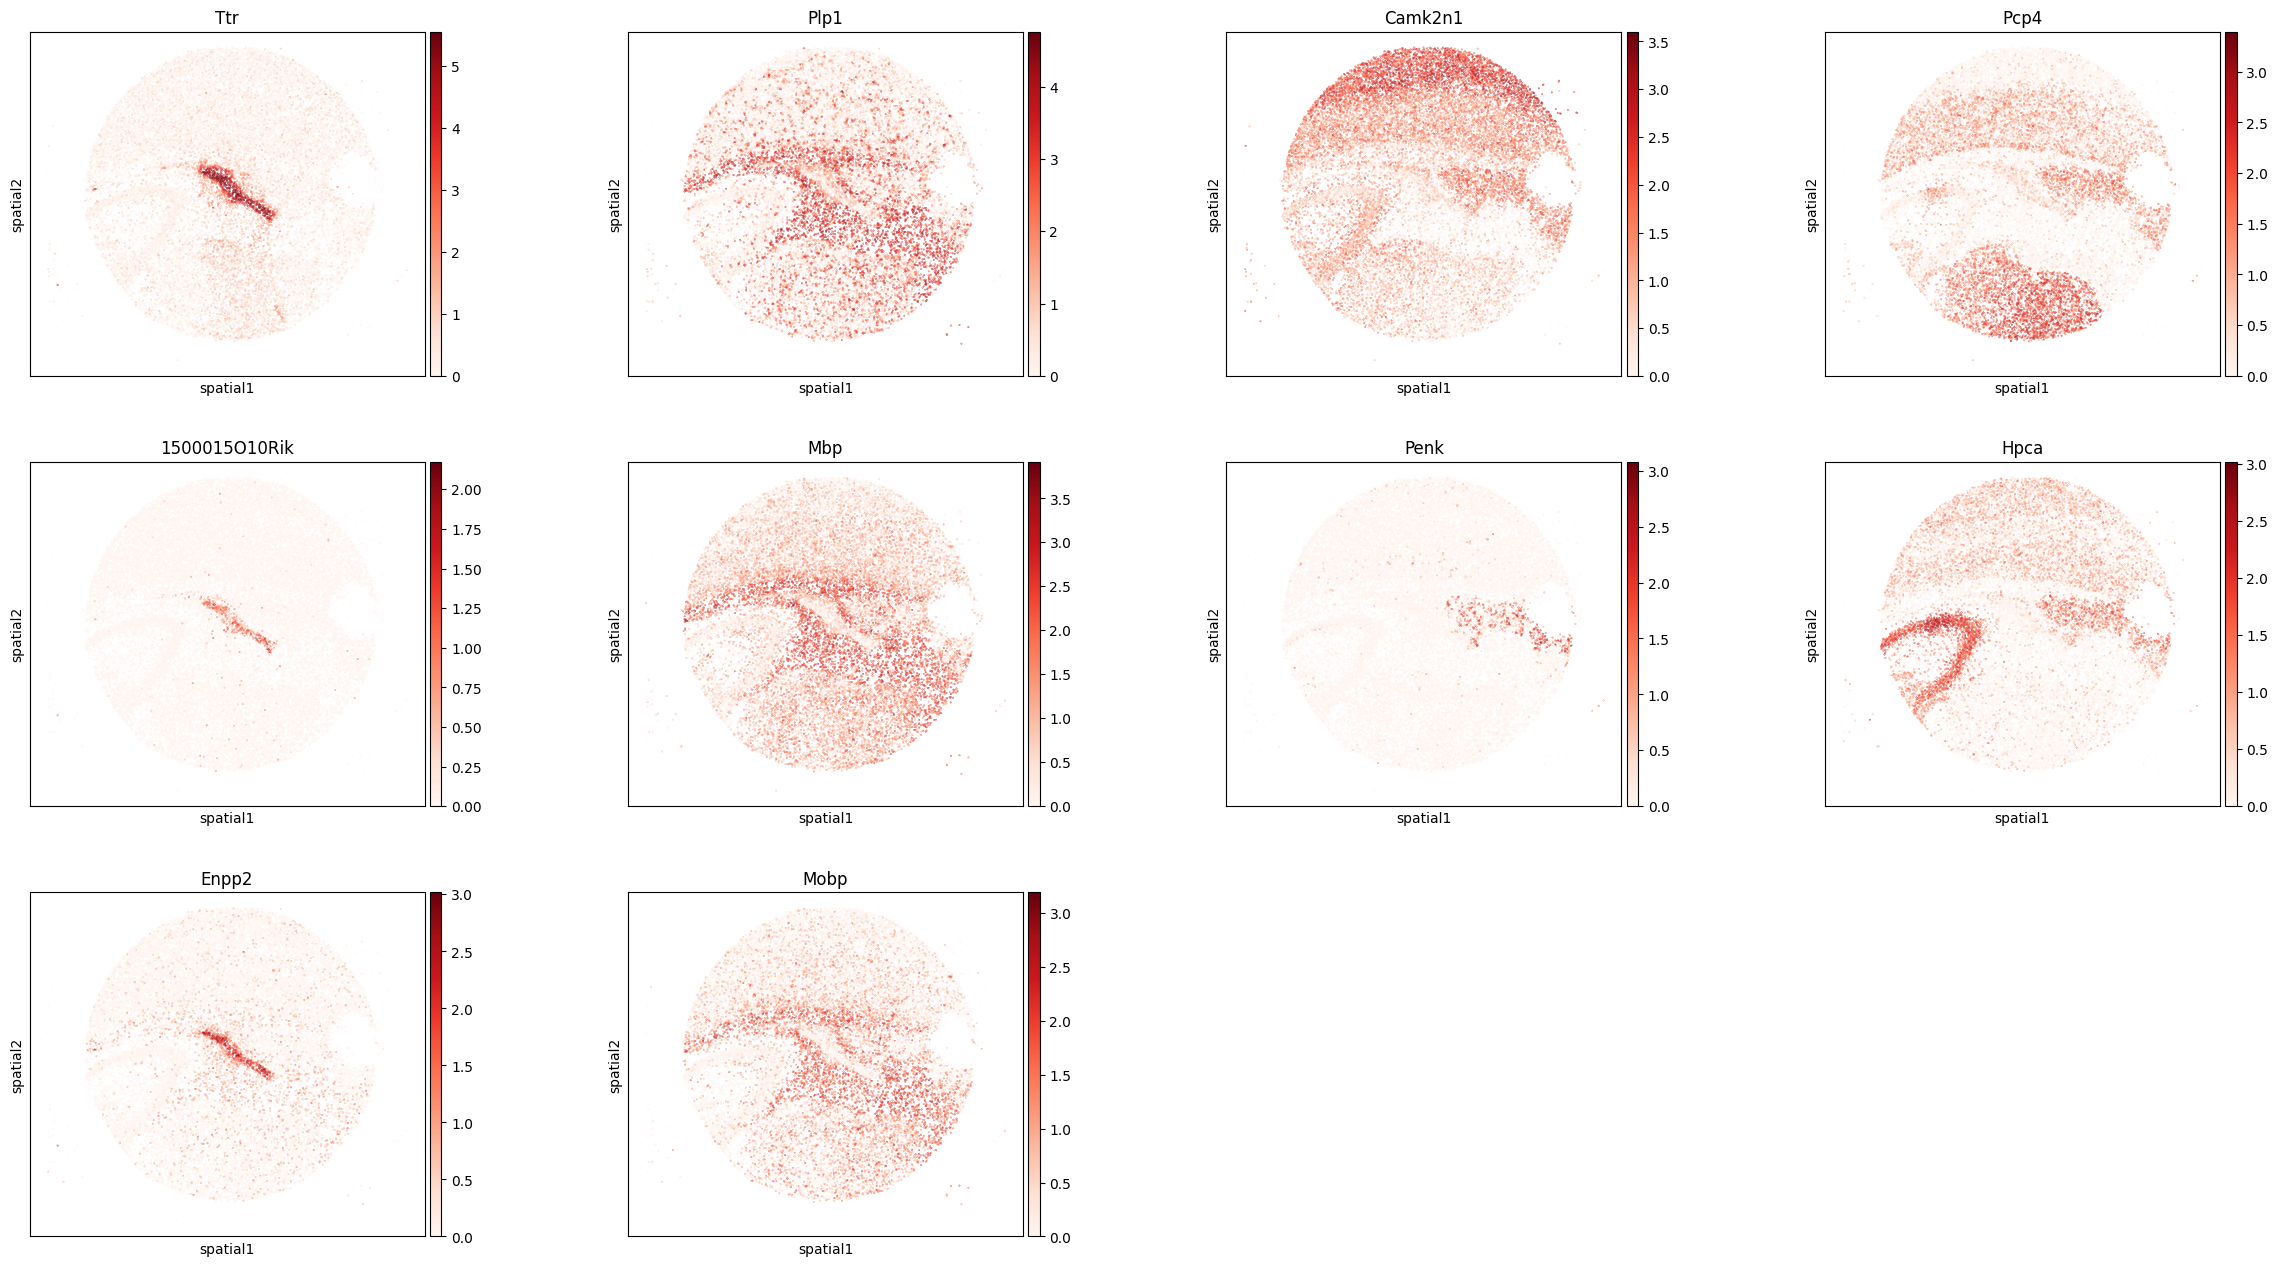

In [14]:
sq.pl.spatial_scatter(
    adata, color=top_autocorr, size=0.1, 
    cmap="Reds", use_raw=False, shape=None
)

In [15]:
adata

View of AnnData object with n_obs × n_vars = 21941 × 10
    obs: 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [16]:
adata.write_h5ad('../../results/00_prepare_reference_data/25_slide_seqv2_Mouse_SomatosensoryCortex.h5ad')